In [2]:
cd /home

/home


In [14]:
import pandas as pd 

import matplotlib.pyplot as plt

import os

In [58]:
folder_dataset = './data/raw_data/alcock/'
metadata = pd.read_csv(os.path.join(folder_dataset, 'metadata.csv'))

In [59]:
metadata['Class'].value_counts()

RRab     7397
EC       6824
LPV      3046
RRc      1762
Cep_0    1182
Cep_1     683
UNK       550
Name: Class, dtype: int64

LPV
Cep_0
RRab
RRc
EC
UNK
Cep_1


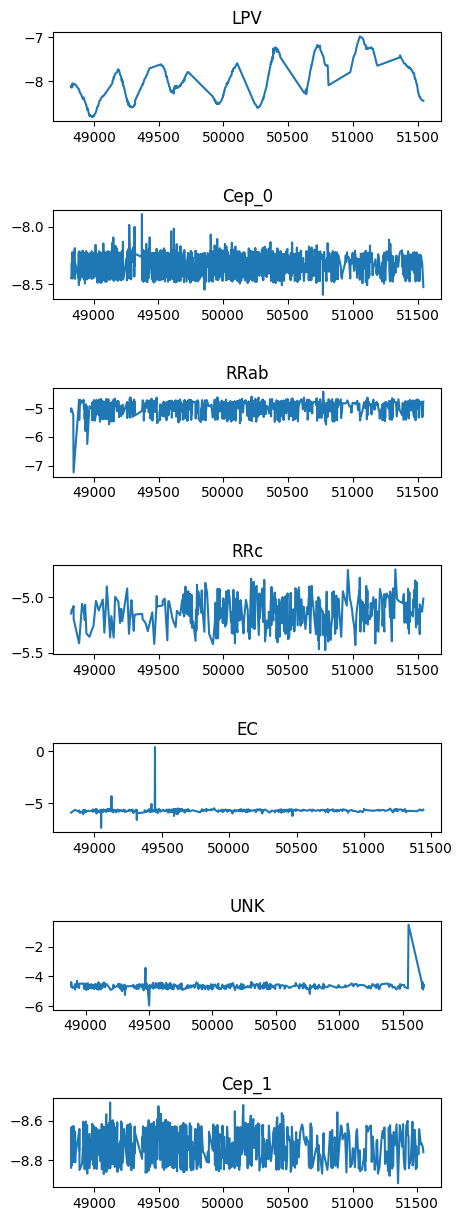

In [63]:
fig, axes = plt.subplots(len(metadata['Class'].unique()),1, figsize=(5,15), gridspec_kw={'hspace': 1, 'wspace': 0.2})

for i, name in enumerate(metadata['Class'].unique()):
    print(name)
    partial_meta = metadata[metadata['Class'] == name]
    sample_id = partial_meta.sample()['Path'].values[0]
    sample = pd.read_csv(os.path.join(folder_dataset, 'LCs', '{}'.format(sample_id)), 
                        )#delim_whitespace=True, 
                #names=['mjd', 'mag', 'err'])
    sample = sample.sort_values('mjd')
    axes[i].plot(sample['mjd'], sample['mag'])
    axes[i].set_title(name)

Text(0.5, 1.0, 'LPV')

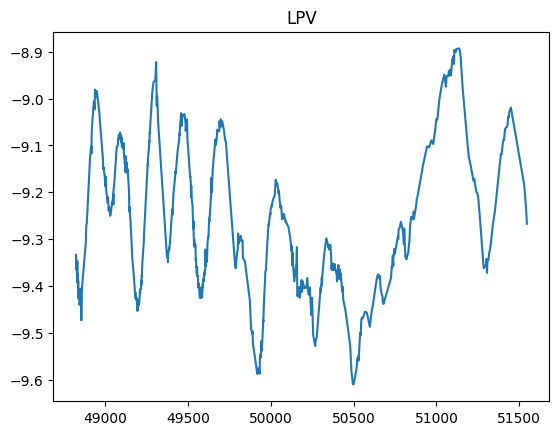

In [79]:
name = 'LPV'
partial_meta = metadata[metadata['Class'] == name]
sample_id = partial_meta.sample()['Path'].values[0]
sample = pd.read_csv(os.path.join(folder_dataset, 'LCs', '{}'.format(sample_id)), 
                    )#delim_whitespace=True, 
            #names=['mjd', 'mag', 'err'])
sample = sample.sort_values('mjd')
plt.plot(sample['mjd'], sample['mag'])
plt.title(name)